In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import h5py
from datetime import datetime

<p style="text-align:center;font-size:3em;font-weight:bold;"> Demonstration of python code for stacking sequence retrieval with F-VQE </p>

⚠ **Disclaimer:** This code repository is provided for demonstration and exploration purposes as part of our competition entry. It is experimental and may contain inaccuracies or incomplete functionality. We encourage others to review and experiment with it, but we do not guarantee correctness or reliability, nor do we accept any responsibility for issues arising from its use.

---

This notebook demonstrates the most important methods and classes that we implemented for applying F-VQE to stacking sequence retrieval, for lamination parameter search and bukcling factor maximization.

# Definition of the laminate

In [2]:
from ssr_with_fvqe.laminate import create_laminate, generate_funcs, Laminate

🔷 Specification of the laminate

In [3]:
num_plies = 8
angles = np.array([0,45,90,-45])
deg = True
symmetric = True
weight_types = 'AD'

# sin(4x) = 0 for conventional angles 
angle_functions = (
    lambda x: np.cos(2 * x),
    lambda x: np.sin(2 * x),
    lambda x: np.cos(4 * x),
    # lambda x: np.sin(4 * x),
)

🔷 Optional rounding for obtaining the precise ply-angle function values in the case of conventional ply angles

In [4]:
funcs_round_decimals = 5
print("Without rounding:")
print(
    generate_funcs(angles, angle_functions, deg)
)

print("\nWith rounding:")
print(
    generate_funcs(angles, angle_functions, deg, funcs_round_decimals)
)

Without rounding:
[[ 1.0000000e+00  0.0000000e+00  1.0000000e+00]
 [ 6.1232340e-17  1.0000000e+00 -1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [ 6.1232340e-17 -1.0000000e+00 -1.0000000e+00]]

With rounding:
[[ 1.  0.  1.]
 [ 0.  1. -1.]
 [-1.  0.  1.]
 [ 0. -1. -1.]]


🔷 Create the `Laminate` instance, which is used to define laminate specifications throughout various methods

In [5]:
laminate: Laminate = create_laminate(
    num_plies, angles, symmetric=symmetric, weight_types=weight_types,
    angle_functions=angle_functions,deg=deg,funcs_round_decimals=funcs_round_decimals   
)

for attr_name in (
    "num_plies", "num_angles",  "num_weights", "num_funcs",
):
    print(f"laminate.{attr_name} = {getattr(laminate, attr_name)}")
for attr_name in ("weights", "funcs"):
    print(f"laminate.{attr_name}.shape = {getattr(laminate, attr_name).shape}")

laminate.num_plies = 8
laminate.num_angles = 4
laminate.num_weights = 2
laminate.num_funcs = 3
laminate.weights.shape = (2, 8)
laminate.funcs.shape = (4, 3)


🔷 Stacking sequences contain the ply-angle indices in `angles`

In [6]:
stack = np.array([0,1,1,0,3,2,3,0])

print(angles[stack])

[  0  45  45   0 -45  90 -45   0]


🔷 Calculating the lamination parameters of the stacking sequence

In [7]:
laminate.parameters(stack)

array([[ 0.25      ,  0.        ,  0.        ],
       [ 0.2265625 , -0.31640625,  0.1640625 ]])

# Constraints

In [8]:
from ssr_with_fvqe.constraints import ConstraintSettings

🔷 The constraints use the following convention:
- **Disorientation constrait:** a matrix, where position `(s1,s2)` is `1` if angles `s1` and `s2` violate the disorientation constraint, and `0` else
- **Contiguity constraint:** an integer for the maximum allowed of consecutive same-angle plies
- **Balanced condition:** A tuple `(s1,s2)` or a list of such tuple, which specifies ply-angles `s1` and `s2` to have the same counts
- **10% rule:** A float for the minimum ratio of all ply-angles (counting balanced angles together), or a list of floats specifying the ratio for angles individually

In [9]:
disorientation_matrix = np.array([[0, 0, 1, 0],
                                  [0, 0, 0, 1],
                                  [1, 0, 0, 0],
                                  [0, 1, 0, 0]])
contiguity_distance = 5
balanced_angles = (1, 3)
percent_rule = 0.1

🔷 Constraints are summarized in the an instance of the `ConstraintSettings` class, which also defines the penalty weights

In [10]:
constraints = ConstraintSettings(
    laminate,
    disorientation_matrix=disorientation_matrix,
    contiguity_distance=contiguity_distance,
    balanced_angles=balanced_angles,
    percent_rule=percent_rule,
    disorientation_penalty=0.05,
    contiguity_penalty=0.05,
    balanced_penalty=0.05,
    percent_penalty=0.05,
)

🔷 The class can be used to count the constraint violations of a stacking sequence, or calculate the penalty

In [11]:
stack = np.array([1,3,3,3,3,3,3,2])
constraints.count_constraint_violations(stack)

{'disorientation': 1, 'contiguity': 1, 'balanced': 5, 'percent': 1}

In [12]:
constraints.penalty(stack)

0.39999999999999997

# Qubit encoding

In [13]:
from ssr_with_fvqe.encoding import (
    stack_to_state, state_to_stack, 
    stack_to_dense, dense_to_stack,
    state_to_dense, dense_to_state
)

🔷 Encoding as a `Sequence` of tuples with `encoding[angle_idx] = (q1,q2,...)` and `q1,q2,... in (0,1)` representing the qubit encoding of `angle_idx`. Functions `state_to_stack` and `stack_to_state` convert between stacking sequences and qubit states

In [14]:
encoding = [
    (0, 0), (0, 1), (1, 1), (1, 0)
]
num_qubits = num_plies * len(encoding[0])

stack = np.array([0,1,1,0,3,2,3,0])

stack_to_state(stack, encoding)

'0001010010111000'

In [15]:
state_to_stack('0001010010111000', encoding)

array([0, 1, 1, 0, 3, 2, 3, 0])

🔷 In some cases, one might also want a dense bit representation of the state

In [16]:
state_dense = stack_to_dense(stack, encoding)
state_dense, dense_to_state(state_dense, num_qubits), dense_to_stack(state_dense, num_qubits, encoding)

(7464, '0001010010111000', array([0, 1, 1, 0, 3, 2, 3, 0]))

# Representation of parameterized quantum circuits

## Hardware efficient (RY, CNOT)

In [17]:
from ssr_with_fvqe.parameterized_state import parameterized_hwe_state

🔷 The class `ParameterizedState` defines a quantum circuit that contains $R_y$ and $\mathrm{CNOT}$. The hardware efficient circuit that we use is generated with `parameterized_hwe_state`.

In [18]:
num_reps = 2
num_qubits = len(encoding[0]) * num_plies

vqc = parameterized_hwe_state(num_qubits, num_reps)

print("Printout VQC layers:\n")
for lidx,layer in enumerate(vqc.layers):
    print(f"Layer {lidx}, gates {layer[0]}:")
    if layer[0] == 'cnot':
        print(" ",*layer[1])
    elif layer[0] == 'ry':
        for n in range(0,len(layer[1]),5):
            print(" ",*(f"({l[0]}, p[{l[1]}])" for l in layer[1][n:n+5]))
    print()

Printout VQC layers:

Layer 0, gates ry:
  (0, p[0]) (1, p[1]) (2, p[2]) (3, p[3]) (4, p[4])
  (5, p[5]) (6, p[6]) (7, p[7]) (8, p[8]) (9, p[9])
  (10, p[10]) (11, p[11]) (12, p[12]) (13, p[13]) (14, p[14])
  (15, p[15])

Layer 1, gates cnot:
  (0, 1) (2, 3) (4, 5) (6, 7) (8, 9) (10, 11) (12, 13) (14, 15)

Layer 2, gates ry:
  (0, p[16]) (1, p[17]) (2, p[18]) (3, p[19]) (4, p[20])
  (5, p[21]) (6, p[22]) (7, p[23]) (8, p[24]) (9, p[25])
  (10, p[26]) (11, p[27]) (12, p[28]) (13, p[29]) (14, p[30])
  (15, p[31])

Layer 3, gates cnot:
  (1, 2) (3, 4) (5, 6) (7, 8) (9, 10) (11, 12) (13, 14)

Layer 4, gates ry:
  (1, p[32]) (2, p[33]) (3, p[34]) (4, p[35]) (5, p[36])
  (6, p[37]) (7, p[38]) (8, p[39]) (9, p[40]) (10, p[41])
  (11, p[42]) (12, p[43]) (13, p[44]) (14, p[45])

Layer 5, gates cnot:
  (0, 1) (2, 3) (4, 5) (6, 7) (8, 9) (10, 11) (12, 13) (14, 15)

Layer 6, gates ry:
  (0, p[46]) (1, p[47]) (2, p[48]) (3, p[49]) (4, p[50])
  (5, p[51]) (6, p[52]) (7, p[53]) (8, p[54]) (9, p[55])


🔷 The parameterized state can be evaluated for specific parameter values. As this circuit only produdes real values, we represent calculated final state vectors as an numpy array with `dtype = float`.

In [19]:
pars = np.random.random(vqc.num_params)*2*np.pi

state_eval = vqc.evaluate(pars)

type(state_eval), state_eval.dtype, state_eval.shape

(numpy.ndarray,
 dtype('float64'),
 (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

🔷 Instead of returning a state vector, one can also sample from the according probability distribution. As F-VQE heavily reuses the energies of the measured state, these are also stored in the `Counts` class, that the sampling method returns. One therefore needs to provide an energy function (and if it is just `lambda x: 0.`) to the sampling method. **The energy function takes the dense integer representation as argument**, this can be achieved with the above mentioned methods to convert and to the required integers.

In [20]:
target_stack = np.array([0,1,1,0,3,2,3,0])
target_parameters = laminate.parameters(target_stack)

energy_fn = lambda x: np.sqrt(np.sum(
    (laminate.parameters(dense_to_stack(x,num_qubits,encoding)) - target_parameters).flatten()**2
))

counts = vqc.sample(pars, energy_fn, shots=1000)

🔷 An instance of `Counts` class 

In [21]:
print("States (in dense bit representation):")
print(counts.states[:10])
print("\nStates:")
print(np.array([dense_to_state(x, num_qubits) for x in counts.states[:10]]))
print("\nCounts:")
print(counts.counts[:10])
print("\nTotal number of counts:", counts.num_counts)
print("\nProbabilities:")
print(counts.probs[:10])
print("\nEnergies:")
print(counts.energies[:10])

States (in dense bit representation):
[   1   23   24   37  920  935 1024 1032 1050 1112]

States:
['1000000000000000' '1110100000000000' '0001100000000000'
 '1010010000000000' '0001100111000000' '1110010111000000'
 '0000000000100000' '0001000000100000' '0101100000100000'
 '0001101000100000']

Counts:
[1 1 1 1 1 1 1 1 1 1]

Total number of counts: 1000

Probabilities:
[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]

Energies:
[1.53463185 1.22534275 1.28349888 1.17725004 0.86307354 0.88211653
 1.25446894 1.03309789 0.7153132  0.63653899]


## Permutation circuit (partial swaps)

In [22]:
from ssr_with_fvqe.parameterized_state_perm import parameterized_perm_state

🔷 The variational quantum circuit implementing permutations using partial swap gates is realized in the `ParameterizedStatePerm` class, which only may contain these partial swap gates. Instead of specifying the fixed gates for preparing the initial state, the initial state is passed directly to the class as a string of `'0'` and `'1'`. The specific circuit that we used, which has one gate for each pair of plies, is generated by the method `parameterized_perm_state`. **The class `ParameterizedStatePerm` is hardcoded for the encoding `[(0,0), (0,1), (1,1), (1,0)]` as it is used throughout this notebook.** 

In [23]:
initial_stack = np.array([0,1,1,0,3,2,3,0])
initial_state = stack_to_state(initial_stack, encoding)

vqc_perm = parameterized_perm_state(initial_state, num_reps=1)

print("Printout VQC layers:\n")
for lidx,layer in enumerate(vqc_perm.layers):
    print(f"Layer {lidx}:")
    for n in range(0,len(layer),3):
        print(" ",*(f"({l[0]}, p[{l[1]}])" for l in layer[n:n+3]))
    print()

Printout VQC layers:

Layer 0:
  ((0, 1, 2, 3), p[0]) ((4, 5, 6, 7), p[1]) ((8, 9, 10, 11), p[2])
  ((12, 13, 14, 15), p[3])

Layer 1:
  ((2, 3, 4, 5), p[4]) ((6, 7, 8, 9), p[5]) ((10, 11, 12, 13), p[6])
  ((14, 15, 0, 1), p[7])

Layer 2:
  ((0, 1, 4, 5), p[8]) ((2, 3, 6, 7), p[9]) ((8, 9, 12, 13), p[10])
  ((10, 11, 14, 15), p[11])

Layer 3:
  ((4, 5, 8, 9), p[12]) ((6, 7, 10, 11), p[13]) ((12, 13, 0, 1), p[14])
  ((14, 15, 2, 3), p[15])

Layer 4:
  ((0, 1, 6, 7), p[16]) ((2, 3, 8, 9), p[17]) ((4, 5, 10, 11), p[18])
  ((12, 13, 2, 3), p[19]) ((14, 15, 4, 5), p[20])

Layer 5:
  ((6, 7, 12, 13), p[21]) ((8, 9, 14, 15), p[22]) ((10, 11, 0, 1), p[23])

Layer 6:
  ((0, 1, 8, 9), p[24]) ((2, 3, 10, 11), p[25]) ((4, 5, 12, 13), p[26])
  ((6, 7, 14, 15), p[27])



🔷 Evaluating state vectors and sampling from the according probability distribution works exactly as in `ParameterizedState`.

In [24]:
pars_perm = np.random.random(vqc_perm.num_params) * 2 * np.pi
vqc_perm.evaluate(pars_perm).shape

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [25]:
type(vqc_perm.sample(pars_perm, energy_fn))

ssr_with_fvqe.counts.Counts

# F-VQE

In [26]:
from ssr_with_fvqe.fvqe import run_fvqe, get_filter_fn

🔷 Generic F-VQE is implemented in the `run_fvqe` method. The type of variational quantum circuit is passed as a string, with `'hwe'` for the HWE circuit and `'perm'` for the permutation circuit above.

In [27]:
filter_fn = get_filter_fn('inverse')

# only 5 iterations for demo
fvqe_results = run_fvqe(
    num_qubits, num_reps, energy_fn, filter_fn,
    shots=1000, maxiter=5, max_tau=200,
    adapt_tau_increment=True, g_c=0.25, vqc='hwe',
    print_info=True    
)

Starting optimization...
Initial energy: 0.9179

Iteration 0
-----------

average tau: 1.0749999999999997
gradient norm: 0.24374527103566812
energy: 0.911935
function calls: 153

timestamp: 00:00:08.80

Iteration 1
-----------

average tau: 0.9809374999999994
gradient norm: 0.24666349490529882
energy: 0.883051
function calls: 153

timestamp: 00:00:17.85

Iteration 2
-----------

average tau: 0.9748066406249998
gradient norm: 0.2440821949777188
energy: 0.874223
function calls: 153

timestamp: 00:00:26.73

Iteration 3
-----------

average tau: 0.9626215576171872
gradient norm: 0.24577538904414165
energy: 0.861659
function calls: 153

timestamp: 00:00:35.54

Iteration 4
-----------

average tau: 0.8904249407958982
gradient norm: 0.24717040494404904
energy: 0.824312
function calls: 153

timestamp: 00:00:45.19



🔷 The method returns an instance of the `FvqeResults` class, which contains information about the optimization

[ 2.76e-02 -9.82e-02 -5.39e-03 -9.25e-02 -4.09e-04 -1.60e-02 -1.02e-01
 -1.12e-01  5.97e-02 -8.92e-03 -1.18e-02  2.99e-03  3.61e-02  7.83e-02
 -7.18e-03 -4.80e-02 -3.68e-02 -1.20e-02 -8.31e-02  1.72e-02 -7.02e-02
 -3.39e-03 -4.32e-03  7.70e-03  1.31e-01  9.25e-03  1.28e-02  1.69e-03
  2.11e-02 -1.60e-02  7.74e-02 -4.50e-02  8.27e-02 -1.34e-01  9.31e-02
 -2.01e-03 -1.45e-02 -3.85e-03 -3.49e-03  1.21e-01 -9.58e-03  3.30e-03
  6.28e-03  1.05e-02  1.29e-01 -1.73e-02  1.29e+00 -1.09e-02 -1.66e-01
 -1.05e-02 -5.74e-03 -1.07e-02 -6.96e-02  1.95e-02 -5.07e-02  8.53e-03
 -3.16e-02 -6.81e-02  5.02e-02  9.36e-02 -1.68e-02  1.52e+00  1.56e+00
  1.41e+00  1.67e+00  1.47e+00  1.57e+00  1.35e+00  1.56e+00  1.45e+00
  1.44e+00  1.55e+00  1.52e+00  1.55e+00  1.32e+00  1.50e+00]


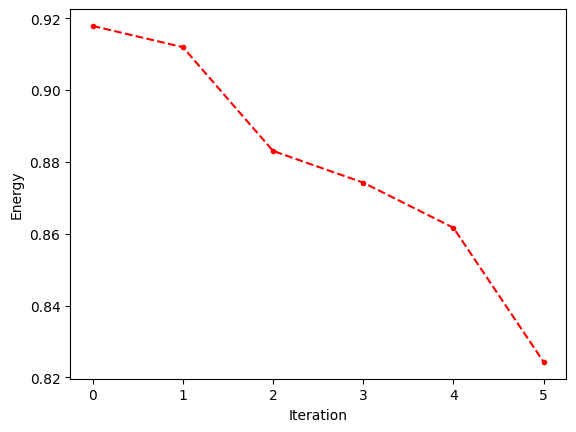

In [28]:
def round_to_num_signif_digits(arr: NDArray[float], precision: int = 1, tol: float = 1e-7):
    mask = (np.abs(arr) > tol) # only use values larger than tolerance
    first_digit = np.ceil(np.log10(np.abs(arr[mask])))
    arr_rounded = np.zeros_like(arr, dtype=float)
    arr_rounded[mask] = (arr[mask] / 10**first_digit).round(decimals = precision) * 10**first_digit
    return arr_rounded
    

# print("Final VQC parameters (rounded to 3 significant digits):")
print(round_to_num_signif_digits(fvqe_results.parameters[-1], precision=3))

fig, ax = plt.subplots()

ax.plot(fvqe_results.energies,'r.--')
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
plt.show()

# Stacking sequence retrieval with F-VQE

In [29]:
from ssr_with_fvqe.fvqe_experiment import FvqeOptions, fvqe_experiment, hdf5_to_fvqe_result

🔷 The two types of experiments for which we employed F-VQE, lamination parameters search and buckling factor maximization, are implemented as seperate functions, which handle building the energy function including the penalties for constraints, run the algorithm and save the data in an HDF5 file. The arguments for `run_fvqe` are collected in an insance of the class `FvqeOptions`.

## Lamination parameter search

In [30]:
# only 5 iterations for demo
fvqe_options = FvqeOptions(
    num_reps=num_reps,
    maxiter=5,
    max_tau=200,
    adapt_tau_increment=True,
    g_c = 0.25,
    filter_fn = 'inverse'
)

filepath = (datetime.now().strftime(
    "C:\\Users\\arnew\\Documents\\ExperimentalData\\vqa\\test_file"
    "_%Y_%m_%d_%H_%M_%S.hdf5"
))

fvqe_experiment(
    filepath, laminate, target_parameters, 
    encoding, fvqe_options, vqc='hwe', lp_loss='rmse', 
    constraint_settings=constraints, print_info=True,
)

Starting optimization...
Initial energy: 1.1074

Iteration 0
-----------

average tau: 0.9625000000000005
gradient norm: 0.2504802497145332
energy: 1.075514
function calls: 153

timestamp: 00:00:20.66

Iteration 1
-----------

average tau: 0.8903125000000008
gradient norm: 0.24443348582657334
energy: 1.063044
function calls: 153

timestamp: 00:00:41.52

Iteration 2
-----------

average tau: 0.9236992187500013
gradient norm: 0.24519049271542173
energy: 1.068656
function calls: 153

timestamp: 00:01:02.4

Iteration 3
-----------

average tau: 0.808236816406251
gradient norm: 0.25003756535295685
energy: 1.055210
function calls: 153

timestamp: 00:01:23.33

Iteration 4
-----------

average tau: 0.788030895996095
gradient norm: 0.24382648488289932
energy: 1.028381
function calls: 153

timestamp: 00:01:44.58



🔷 An instance of `FvqeResults` can be easily retrieved from the file.

Final VQC parameters (rounded to 3 significant digits):
[ 1.09e-02  6.70e-04  4.76e-02 -5.85e-02  2.53e-02 -1.70e-01 -5.30e-02
 -2.14e-01  6.75e-04  1.81e-01 -9.28e-03 -5.73e-02  6.18e-02  5.32e-02
 -5.84e-02 -6.58e-02 -1.47e-01 -6.02e-02 -2.26e-02 -6.81e-04 -6.10e-02
 -1.26e-02  1.09e-01 -1.97e-03  4.65e-02  1.60e-03  6.43e-03  4.37e-03
  1.61e-03  1.04e-02 -7.40e-03 -6.81e-02  6.41e-02 -7.85e-02  7.47e-02
  1.22e-03 -1.25e-01 -7.32e-03  4.00e-03  7.50e-02 -2.74e-03  1.02e-02
 -5.73e-02  2.62e-02  1.14e-01  1.97e-01  1.35e+00 -6.50e-03 -2.16e-01
  6.13e-02 -9.62e-02  9.84e-03 -6.01e-02 -1.33e-01 -3.32e-02  3.82e-03
  4.95e-02  9.17e-03  2.67e-02  5.86e-02 -2.00e-02  1.52e+00  1.55e+00
  1.38e+00  1.67e+00  1.59e+00  1.62e+00  1.49e+00  1.59e+00  1.54e+00
  1.52e+00  1.55e+00  1.52e+00  1.54e+00  1.37e+00  1.57e+00]


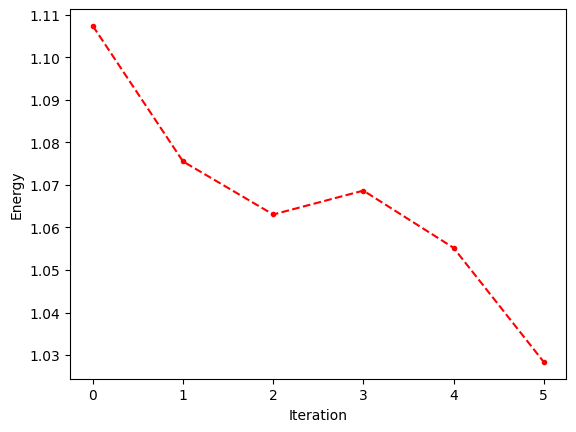

In [31]:
results = hdf5_to_fvqe_result(filepath)

print("Final VQC parameters (rounded to 3 significant digits):")
print(round_to_num_signif_digits(results.parameters[-1], precision=3))

fig, ax = plt.subplots()

ax.plot(results.energies,'r.--')
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
plt.show()

## Buckling factor maximization

In [32]:
from ssr_with_fvqe.fvqe_experiment_buckling import fvqe_experiment_buckling

🔷 The buckling factor depends on material properties, stresses and dimensions of the plate

In [33]:
material_opts = dict(
    E1 = 177.,  # GPa
    E2 = 10.8,  # GPa
    G12 = 7.6,  # GPa
    nu12 = 0.27,
    a = 1.,     # m
    b = 1.,     # m
    Nx = 2.,    # kN/m
    Ny = 1.,    # kN/m
    h = 1.,     # m
    n = 1,
    m = 1
)

🔷 The method for the buckling experiment `fvqe_experiment_buckling` requires the target ply angle counts instead of lamination parameters, but also a positive constant `max_buckling_factor` that should be larger then the largest possible buckling factor. This constant is added to the energy function to make it values positive, as it contains the negative buckling factor to enable minimization instead of maximization.

In [34]:
filepath = (datetime.now().strftime(
    "C:\\Users\\arnew\\Documents\\ExperimentalData\\vqa\\test_file_buckling"
    "_%Y_%m_%d_%H_%M_%S.hdf5"
))

# only 5 iterations for demo
fvqe_options = FvqeOptions(
    num_reps=1,
    maxiter=5,
    max_tau=200,
    adapt_tau_increment=True,
    g_c = 0.1,
    filter_fn = 'exponential'
)

ply_angle_counts = np.array([1, 2, 3, 2])
assert ply_angle_counts.sum() == num_plies

max_buckling_factor = 130

results_buckling = fvqe_experiment_buckling(
    filepath, laminate, ply_angle_counts, max_buckling_factor,
    encoding, fvqe_options,
    constraint_settings=constraints,
    material_opts = material_opts,
    print_info=True,
    vqc='perm'
)

Starting optimization...
Initial energy: 30.8389

Iteration 0
-----------

average tau: 0.10000000000000002
gradient norm: 0.7951063017898952
energy: 29.563246
function calls: 57

timestamp: 00:00:05.13

Iteration 1
-----------

average tau: 0.03500000000000001
gradient norm: 0.10207539112264477
energy: 30.065194
function calls: 57

timestamp: 00:00:09.91

Iteration 2
-----------

average tau: 0.03150000000000001
gradient norm: 0.08601088044462825
energy: 29.666691
function calls: 57

timestamp: 00:00:14.70

Iteration 3
-----------

average tau: 0.03150000000000001
gradient norm: 0.09882982462937727
energy: 29.322411
function calls: 57

timestamp: 00:00:19.81

Iteration 4
-----------

average tau: 0.03150000000000001
gradient norm: 0.09315609262414244
energy: 29.277213
function calls: 57

timestamp: 00:00:24.56



Final VQC parameters (rounded to 3 significant digits):
[1.65 1.56 1.52 1.6  1.5  1.63 1.64 1.85 1.51 1.76 1.48 1.58 1.7  1.32
 2.25 1.76 1.22 1.59 1.75 1.38 1.8  1.66 1.34 1.61 1.53 1.82 1.73 1.54]


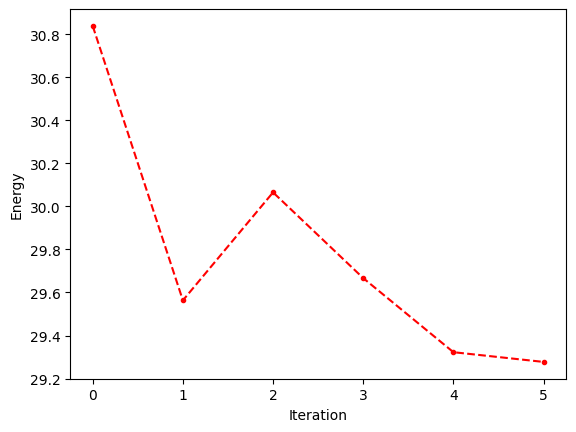

In [35]:
results = hdf5_to_fvqe_result(filepath)

print("Final VQC parameters (rounded to 3 significant digits):")
print(round_to_num_signif_digits(results.parameters[-1], precision=3))

fig, ax = plt.subplots()

ax.plot(results.energies,'r.--')
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
plt.show()

# Appendix

## Why use our own statevector simulator? A comparison between circuit evaluations of `ParameterizedState` and Qiskit statevectors

In [36]:
from ssr_with_fvqe.parameterized_state import ParameterizedState
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import Statevector

🔷 We started out using *Qiskit* for our simulations, but then moved to a custom implementation as *Qiskit*'s local simulation capabilities are not only limited, but also fairly inefficient. We thus leveraged the specific gate set in our quantum circuits to achieve a direct implementation of the gates on the elements of a statevector. This is generally more efficient than the general matrix based approach that for example *Qiskit* employs when converting from quantum circuits and state vectors on a local computer.

In [37]:
def build_hwe_circuit_qiskit(num_qubits: int, num_reps: int) -> QuantumCircuit:
    """Create hardware efficient variational circuit

    Args:
        num_qubits (int): The number of qubits
        num_reps (int): The number of repetitions in the circuit

    Returns:
        QuantumCircuit: The variational circuit

    """
    qc = QuantumCircuit(num_qubits)
    num_pars_rep = 2 * num_qubits - 2
    num_parameters = num_qubits + num_reps * num_pars_rep
    pars = ParameterVector('p', num_parameters)
    # print(len(pars))
    for q in range(num_qubits):
        qc.ry(pars[q], q)
    par_counter = num_qubits
    for r in range(num_reps):
        for q in range(0, num_qubits - 1, 2):  # minus 1 to exclude last qubits
            qc.cx(q, q + 1)
            qc.ry(pars[par_counter], q)
            qc.ry(pars[par_counter + 1], q + 1)
            par_counter += 2
        for q in range(1, num_qubits - 1, 2):
            qc.cx(q, q + 1)
            qc.ry(pars[par_counter], q)
            qc.ry(pars[par_counter + 1], q + 1)
            par_counter += 2
    assert par_counter == num_parameters
    return qc

🔷 When accounting correctly for the ordering of qubits in the respective implementations, they yield the same results (up to rounding errors `< 1e12`)

In [38]:
num_qubits = 16
num_reps = 2

qc: QuantumCircuit = build_hwe_circuit_qiskit(num_qubits,num_reps)
parameterized_state: ParameterizedState = parameterized_hwe_state(num_qubits,num_reps)

param_values = np.random.rand(qc.num_parameters) * 2 * np.pi

statevec_qiskit = Statevector(qc.assign_parameters(param_values))
statevec_qiskit_data = np.array([statevec_qiskit[dense_to_state(x, num_qubits)] for x in range(2**num_qubits)])

statevec_parameterized_state = parameterized_state.evaluate(param_values).flatten()

np.abs(statevec_qiskit_data - statevec_parameterized_state).sum().round(decimals = 12)

np.float64(0.0)

🔷 But our implementation runs significantly faster, which means that the effort of implementing this ourselves was definitely worth it 😁

In [39]:
import timeit

num_trials = 100

def benchmark_qiskit():
    return Statevector(qc.assign_parameters(param_values))

def benchmark_parameterized_state():
    return parameterized_state.evaluate(param_values)

# Run the benchmarks
qiskit_time = timeit.timeit(benchmark_qiskit, number=num_trials)
parameterized_state_time = timeit.timeit(benchmark_parameterized_state, number=num_trials)

# Print the average execution time
print(f"Qiskit Statevector average time: {qiskit_time / num_trials:.6f} seconds")
print(f"ParameterizedState evaluate average time: {parameterized_state_time / num_trials:.6f} seconds")

Qiskit Statevector average time: 0.171739 seconds
ParameterizedState evaluate average time: 0.028070 seconds
